In [1]:
import sys
print(sys.executable)
neural_struct_dir = '/mnt/g/PythonWorkspace/neural-structural-optimization/'
sys.path.insert(0, neural_struct_dir)
# hardcoded
cur_file_dir = '/mnt/g/PythonWorkspace/neural-structural-optimization/projects'
sys.path.insert(0, cur_file_dir)

/home/shushu/install/anaconda3/envs/neural-struct/bin/python


In [2]:
import matplotlib.pyplot as plt
import xarray
import tensorflow as tf
import time
import os
import pandas as pd

from neural_structural_optimization import problems
from neural_structural_optimization import topo_api
from neural_structural_optimization import train
from neural_structural_optimization.models import *
from cnn_sketch import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

2021-08-19 19:03:40.188590: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-19 19:03:40.188633: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
# print(problems.PROBLEMS_BY_NAME.keys())

## CNNModel
```python
def __init__(
      self,
      seed=0,
      args=None,
      latent_size=128,  
      dense_channels=32,   
      resizes=(1, 2, 2, 2, 1),  # the deeper, the better?
      conv_filters=(128, 64, 32, 16, 1),  # 1 16 32 ...
      offset_scale=10,
      kernel_size=(5, 5),
      latent_scale=1.0,
      dense_init_scale=1.0,
      activation=tf.nn.tanh,
      conv_initializer=tf.initializers.VarianceScaling,
      normalization=global_normalization,
      volume_contraint=True,
      cone_filter=True
  ):
```
We keep lattent size, number of channels of dense layer, kernel size as default, only test on hyperparameters of resizes and conv_filters.

## 3 layer CNN model

In [3]:
problem_mbb = problems.mbb_beam(width=64, height=32, density=0.5)
args_mbb = topo_api.specified_task(problem_mbb)
# print(args_mbb)

In [4]:
cnn3_mbb = CNNModel(args=args_mbb, resizes=(1,2,1), conv_filters=(32,16,1))

2021-08-19 19:03:43.628451: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-19 19:03:43.628501: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-19 19:03:43.628541: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-EOPHS13E): /proc/driver/nvidia/version does not exist
2021-08-19 19:03:43.628797: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
tic = time.perf_counter()
ds_cnn3_mbb = train.train_lbfgs(cnn3_mbb, 100)
toc = time.perf_counter()
print('Ellapsed time of training: %.2fs' % (toc-tic))

Ellapsed time of training: 29.70s


In [6]:
# saved_dir = os.path.join(cur_file_dir, 'saved_models')
# cnn3_mbb.save_weights(os.path.join(saved_dir, 'cnn3_mbb100'))

In [7]:
cnn3_mbb_no_cone = CNNModel(args=args_mbb, resizes=(1,2,1), conv_filters=(32,16,1), cone_filter = False)
tic = time.perf_counter()
ds_cnn3_mbb_no_cone = train.train_lbfgs(cnn3_mbb_no_cone, 100)
toc = time.perf_counter()
print('Ellapsed time of training: %.2fs' % (toc-tic))

Ellapsed time of training: 30.78s


<xarray.DataArray 'loss' ()>
array(86.0279536)
Coordinates:
    step     int64 100


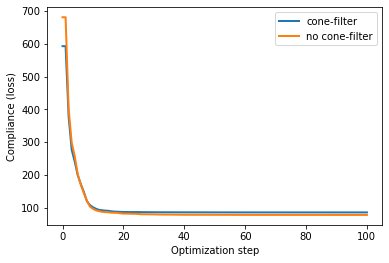

In [8]:
ds_cnn3_mbb.loss.transpose().to_pandas().cummin().loc[:200].plot(linewidth=2, label='cone-filter')
ds_cnn3_mbb_no_cone.loss.transpose().to_pandas().cummin().loc[:200].plot(linewidth=2, label='no cone-filter')
plt.ylabel('Compliance (loss)')
plt.xlabel('Optimization step')
plt.legend(loc='best')
print(ds_cnn3_mbb.loss.sel(step=100))

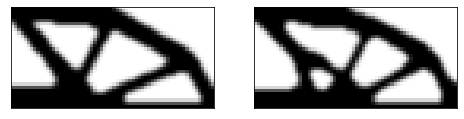

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(8,6),subplot_kw={'xticks': [], 'yticks': []})
ax[0].imshow(ds_cnn3_mbb.design.sel(step=100), cmap='Greys')
ax[1].imshow(ds_cnn3_mbb_no_cone.design.sel(step=100), cmap='Greys')

### Compare with CNN sketch

In [10]:
class CNNSketch3(Model):

  def __init__(
      self,
      seed=0,
      args=None,
      latent_size = 128,
      dense_channels = 32,
      latent_scale=1.0,
      dense_init_scale=1.0,
      activation = tf.nn.tanh,
      volume_contraint = True,
      cone_filter = True
  ):
    super().__init__(seed, args, volume_contraint, cone_filter)

    activation = layers.Activation(activation)

    h = self.env.args['nely'] // 2
    w = self.env.args['nelx'] // 2
    
    net = inputs = layers.Input((latent_size,), batch_size=1)
    filters = h * w * dense_channels   # 32 * h/2 * w/2
    dense_initializer = tf.initializers.orthogonal(
        dense_init_scale * np.sqrt(max(filters / latent_size, 1)))
    net = layers.Dense(filters, kernel_initializer=dense_initializer)(net)
    net = layers.Reshape([h, w, dense_channels])(net)  
    
    net = FlatConv3(net, 32, activation)  # 32 * h/2 * w/2

    net = UpConv4(net, 16, activation)  # 16 * h * w
    
    net = layers.Conv2D(1, 3, padding='same')(net)  # 1 * h * w
    
    outputs = tf.squeeze(net, axis=[-1])

    self.core_model = tf.keras.Model(inputs=inputs, outputs=outputs)

    latent_initializer = tf.initializers.RandomNormal(stddev=latent_scale)
    self.z = self.add_weight(
        shape=inputs.shape, initializer=latent_initializer, name='z')

  def call(self, inputs=None):
    return self.core_model(self.z)

In [11]:
cnns3_mbb = CNNSketch3(args=args_mbb, volume_contraint=True, cone_filter = True)
tic = time.perf_counter()
ds_cnns3_mbb = train.train_lbfgs(cnns3_mbb, 100)
toc = time.perf_counter()
print('Ellapsed time of training: %.2fs' % (toc-tic))

Ellapsed time of training: 27.75s


Text(0.5, 0, 'Optimization step')

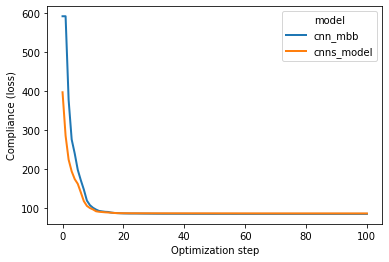

In [56]:
dims = pd.Index(['cnn_mbb', 'cnns_model'], name='model')
ds =  xarray.concat([ds_cnn3_mbb, ds_cnns3_mbb], dim=dims)
ds.loss.transpose().to_pandas().cummin().loc[:200].plot(linewidth=2)
plt.ylabel('Compliance (loss)')
plt.xlabel('Optimization step')

In [13]:
cnns3_mbb_no_conefilter = CNNSketch3(args=args_mbb, volume_contraint=True, cone_filter = False)
tic = time.perf_counter()
ds_cnns3_mbb_no_conefilter = train.train_lbfgs(cnns3_mbb_no_conefilter, 100)
toc = time.perf_counter()
print('Ellapsed time of training: %.2fs' % (toc-tic))

Ellapsed time of training: 27.30s


In [14]:
class CNNSketch3_sigm(Model):

  def __init__(
      self,
      seed=0,
      args=None,
      latent_size = 128,
      dense_channels = 32,
      latent_scale=1.0,
      dense_init_scale=1.0,
      activation = tf.nn.tanh,
      volume_contraint = True,
      cone_filter = True
  ):
    super().__init__(seed, args, volume_contraint, cone_filter)

    activation = layers.Activation(activation)

    h = self.env.args['nely'] // 2
    w = self.env.args['nelx'] // 2
    
    net = inputs = layers.Input((latent_size,), batch_size=1)
    filters = h * w * dense_channels   # 32 * h/2 * w/2
    dense_initializer = tf.initializers.orthogonal(
        dense_init_scale * np.sqrt(max(filters / latent_size, 1)))
    net = layers.Dense(filters, kernel_initializer=dense_initializer)(net)
    net = layers.Reshape([h, w, dense_channels])(net)  
    
    net = FlatConv3(net, 32, activation)  # 32 * h/2 * w/2

    net = UpConv4(net, 16, activation)  # 16 * h * w
    
    net = layers.Conv2D(1, 3, padding='same')(net)  # 1 * h * w
    net = tf.nn.sigmoid(net) 
    
    outputs = tf.squeeze(net, axis=[-1])

    self.core_model = tf.keras.Model(inputs=inputs, outputs=outputs)

    latent_initializer = tf.initializers.RandomNormal(stddev=latent_scale)
    self.z = self.add_weight(
        shape=inputs.shape, initializer=latent_initializer, name='z')

  def call(self, inputs=None):
    return self.core_model(self.z)

In [15]:
cnns3_sigm_mbb_no_conefilter = CNNSketch3_sigm(args=args_mbb, volume_contraint=True, cone_filter=False)
tic = time.perf_counter()
ds_cnns3_sigm_mbb_no_conefilter = train.train_lbfgs(cnns3_sigm_mbb_no_conefilter, 100)
toc = time.perf_counter()
print('Ellapsed time of training: %.2fs' % (toc-tic))

Ellapsed time of training: 27.68s


In [16]:
cnns3_sigm_mbb = CNNSketch3_sigm(args=args_mbb, volume_contraint=True, cone_filter=True)
tic = time.perf_counter()
ds_cnns3_sigm_mbb = train.train_lbfgs(cnns3_sigm_mbb, 100)
toc = time.perf_counter()
print('Ellapsed time of training: %.2fs' % (toc-tic))

Ellapsed time of training: 26.57s


We don't need a sigmoid function or any other activation function as the last layer. This is due to the fact that the constraint filter afterwards can also map the logits to [0,1].

Text(0, 0.5, 'without sigmoid')

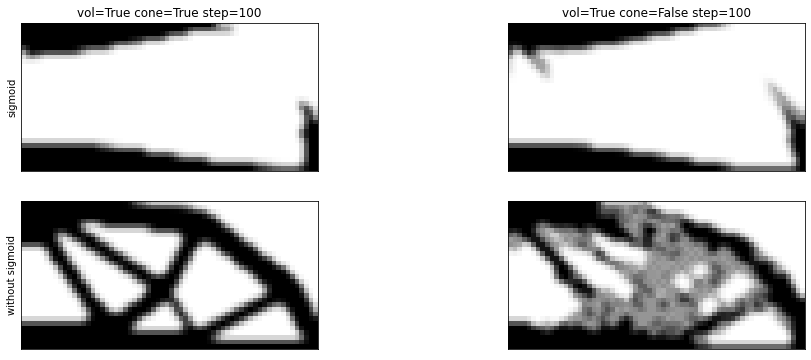

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(16,6),subplot_kw={'xticks': [], 'yticks': []})
ax[0,0].imshow(ds_cnns3_sigm_mbb.design.sel(step=100), cmap='Greys')
ax[0,1].imshow(ds_cnns3_sigm_mbb_no_conefilter.design.sel(step=100), cmap='Greys')
ax[0,0].set_ylabel('sigmoid')
ax[0,0].set_title('vol=True cone=True step=100')
ax[0,1].set_title('vol=True cone=False step=100')
# ax[0,3].set_title('False False 20')
ax[1,0].imshow(ds_cnns3_mbb.design.sel(step=100), cmap='Greys')
ax[1,1].imshow(ds_cnns3_mbb_no_conefilter.design.sel(step=100), cmap='Greys')
ax[1,0].set_ylabel('without sigmoid')

## 4 CNN layer

In [19]:
cnn4_mbb = CNNModel(args=args_mbb, resizes=(1,2, 2, 1), conv_filters=(64, 32,16,1))
tic = time.perf_counter()
ds_cnn4_mbb = train.train_lbfgs(cnn4_mbb, 100)
toc = time.perf_counter()
print('Ellapsed time of training: %.2fs' % (toc-tic))

Ellapsed time of training: 14.91s


In [20]:
ds_cnn4_mbb

<xarray.Dataset>
Dimensions:  (step: 101, y: 32, x: 64)
Coordinates:
  * step     (step) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99 100
Dimensions without coordinates: y, x
Data variables:
    loss     (step) float64 663.8 588.0 238.4 181.5 ... 91.03 90.93 90.93 90.92
    design   (step, y, x) float64 0.5284 0.5023 0.5235 0.5967 ... 1.0 1.0 1.0

In [21]:
class CNNSketch4(Model):

  def __init__(
      self,
      seed=0,
      args=None,
      latent_size = 128,
      dense_channels = 32,
      latent_scale=1.0,
      dense_init_scale=1.0,
      activation = tf.nn.tanh
  ):
    super().__init__(seed, args)

    activation = layers.Activation(activation)

    h = self.env.args['nely'] // 4
    w = self.env.args['nelx'] // 4
    
    net = inputs = layers.Input((latent_size,), batch_size=1)
    filters = h * w * dense_channels   # 32 * h/4 * w/4
    dense_initializer = tf.initializers.orthogonal(
        dense_init_scale * np.sqrt(max(filters / latent_size, 1)))
    net = layers.Dense(filters, kernel_initializer=dense_initializer)(net)
    net = layers.Reshape([h, w, dense_channels])(net)  
    
    net = FlatConv3(net, 64, activation)  # 64 * h * w

    net = UpConv4(net, 32, activation)  # 32 * h/2 * w/2
    
    net = UpConv4(net, 16, activation)  # 16 * h * w
    
    net = layers.Conv2D(1, 3, padding='same')(net)  # 1 * h * w
    
    outputs = tf.squeeze(net, axis=[-1])

    self.core_model = tf.keras.Model(inputs=inputs, outputs=outputs)

    latent_initializer = tf.initializers.RandomNormal(stddev=latent_scale)
    self.z = self.add_weight(
        shape=inputs.shape, initializer=latent_initializer, name='z')

  def call(self, inputs=None):
    return self.core_model(self.z)

In [22]:
cnns4_mbb = CNNSketch4(args=args_mbb)
tic = time.perf_counter()
ds_cnns4_mbb = train.train_lbfgs(cnns4_mbb, 100)
toc = time.perf_counter()
print('Ellapsed time of training: %.2fs' % (toc-tic))

Ellapsed time of training: 12.69s


Text(0.5, 0, 'Optimization step')

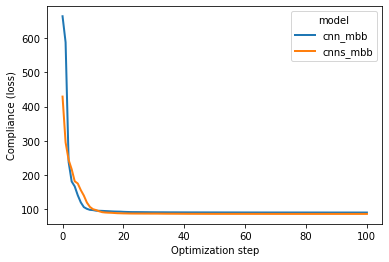

In [23]:
dims = pd.Index(['cnn_mbb', 'cnns_mbb'], name='model')
ds =  xarray.concat([ds_cnn4_mbb, ds_cnns4_mbb], dim=dims)
ds.loss.transpose().to_pandas().cummin().loc[:200].plot(linewidth=2)
plt.ylabel('Compliance (loss)')
plt.xlabel('Optimization step')

With same building block, the depth of NN has influence on the optimized results. 

Text(0.5, 1.0, 'cnns_mbb')

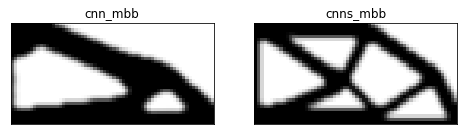

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(8,6),subplot_kw={'xticks': [], 'yticks': []})
ax[0].imshow(ds_cnn4_mbb.design.sel(step=100), cmap='Greys')
ax[0].set_title('cnn_mbb')
ax[1].imshow(ds_cnns4_mbb.design.sel(step=100), cmap='Greys')
ax[1].set_title('cnns_mbb')

## 5 CNN layer

In [25]:
cnn5_mbb = CNNModel(args=args_mbb, resizes=(1, 2, 2, 2, 1), conv_filters=(128, 64, 32,16,1))
tic = time.perf_counter()
ds_cnn5_mbb = train.train_lbfgs(cnn5_mbb, 100)
toc = time.perf_counter()
print('Ellapsed time of training: %.2fs' % (toc-tic))

Ellapsed time of training: 14.69s


In [26]:
class CNNSketch5(Model):

  def __init__(
      self,
      seed=0,
      args=None,
      latent_size = 128,
      dense_channels = 32,
      latent_scale=1.0,
      dense_init_scale=1.0,
      activation = tf.nn.tanh
  ):
    super().__init__(seed, args)

    activation = layers.Activation(activation)

    h = self.env.args['nely'] // 8
    w = self.env.args['nelx'] // 8
    
    net = inputs = layers.Input((latent_size,), batch_size=1)
    filters = h * w * dense_channels   # 32 * h/8 * w/8
    dense_initializer = tf.initializers.orthogonal(
        dense_init_scale * np.sqrt(max(filters / latent_size, 1)))
    net = layers.Dense(filters, kernel_initializer=dense_initializer)(net)
    net = layers.Reshape([h, w, dense_channels])(net)  
    
    net = FlatConv3(net, 128, activation)  # 128 * h/8 * w/8

    net = UpConv4(net, 64, activation)  # 64 * h/4 * w/4
    
    net = UpConv4(net, 32, activation)  # 32 * h/2 * w/2
    
    net = UpConv4(net, 32, activation)  # 16 * h * w
    
    net = layers.Conv2D(1, 3, padding='same')(net)  # 1 * h * w
#     net = tf.nn.sigmoid(net)  # no much difference in results with or without the sigmoid layer
    
    outputs = tf.squeeze(net, axis=[-1])

    self.core_model = tf.keras.Model(inputs=inputs, outputs=outputs)

    latent_initializer = tf.initializers.RandomNormal(stddev=latent_scale)
    self.z = self.add_weight(
        shape=inputs.shape, initializer=latent_initializer, name='z')

  def call(self, inputs=None):
    return self.core_model(self.z)

In [27]:
cnns5_mbb = CNNSketch5(args=args_mbb)
tic = time.perf_counter()
ds_cnns5_mbb = train.train_lbfgs(cnns5_mbb, 100)
toc = time.perf_counter()
print('Ellapsed time of training: %.2fs' % (toc-tic))

Ellapsed time of training: 10.80s


Text(0.5, 0, 'Optimization step')

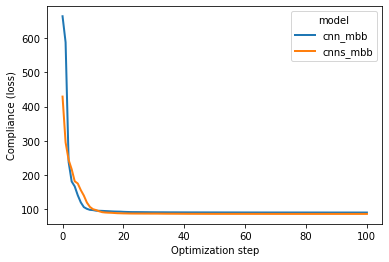

In [28]:
dims = pd.Index(['cnn_mbb', 'cnns_mbb'], name='model')
ds =  xarray.concat([ds_cnn4_mbb, ds_cnns4_mbb], dim=dims)
ds.loss.transpose().to_pandas().cummin().loc[:200].plot(linewidth=2)
plt.ylabel('Compliance (loss)')
plt.xlabel('Optimization step')

Designs from CNN are often simpler than those from CNNSketch

Text(0.5, 1.0, 'cnns_mbb')

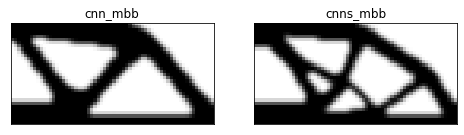

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(8,6),subplot_kw={'xticks': [], 'yticks': []})
ax[0].imshow(ds_cnn5_mbb.design.sel(step=100), cmap='Greys')
ax[0].set_title('cnn_mbb')
ax[1].imshow(ds_cnns5_mbb.design.sel(step=100), cmap='Greys')
ax[1].set_title('cnns_mbb')

## Try another problem

In [30]:
problem_asb = problems.PROBLEMS_BY_NAME["anchored_suspended_bridge_128x128_0.1"]
args_asb = topo_api.specified_task(problem_asb)

In [32]:
cnn3_asb = CNNModel(args=args_asb, resizes=(1,2,1), conv_filters=(32,16,1))

In [33]:
tic = time.perf_counter()
ds_cnn3_asb = train.train_lbfgs(cnn3_asb, 100)
toc = time.perf_counter()
print('Ellapsed time of training: %.2fs' % (toc-tic))

Ellapsed time of training: 317.86s


In [ ]:
cnns3_asb= CNNSketch5(args=args_asb)
tic = time.perf_counter()
ds_cnns3_asb= train.train_lbfgs(cnns3_asb, 100)
toc = time.perf_counter()
print('Ellapsed time of training: %.2fs' % (toc-tic))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4,3),subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(ds_cnn1_asb.design.sel(step=100), cmap='Greys')

## Cantilever beam example

In [13]:
problem_cb = problems.PROBLEMS_BY_NAME['cantilever_beam_two_point_64x48_0.4']
args_cb = topo_api.specified_task(problem_cb)

### 3 layer

In [14]:
cnn3_cb = CNNModel(args=args_cb, resizes=(1,2,1), conv_filters=(32,16,1))
tic = time.perf_counter()
ds_cnn3_cb = train.train_lbfgs(cnn3_cb, 100)
toc = time.perf_counter()
print('Ellapsed time of training: %.2fs' % (toc-tic))

Ellapsed time of training: 46.03s


In [21]:
cnns3_cb = CNNSketch3(args=args_cb)
tic = time.perf_counter()
ds_cnns3_cb = train.train_lbfgs(cnns3_cb, 100)
toc = time.perf_counter()
print('Ellapsed time of training: %.2fs' % (toc-tic))

Ellapsed time of training: 39.88s


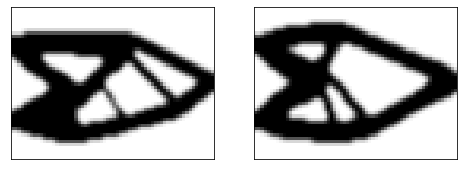

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(8,6),subplot_kw={'xticks': [], 'yticks': []})
ax[0].imshow(ds_cnn3_cb.design.sel(step=100), cmap='Greys')
ax[1].imshow(ds_cnns3_cb.design.sel(step=100), cmap='Greys')

Text(0.5, 0, 'Optimization step')

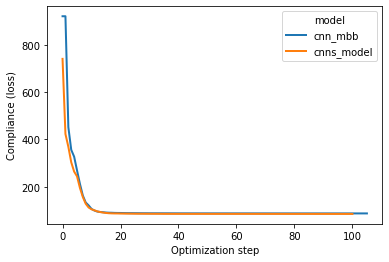

In [23]:
dims = pd.Index(['cnn_mbb', 'cnns_model'], name='model')
ds =  xarray.concat([ds_cnn3_cb, ds_cnns3_cb], dim=dims)
ds.loss.transpose().to_pandas().cummin().loc[:200].plot(linewidth=2)
plt.ylabel('Compliance (loss)')
plt.xlabel('Optimization step')

### 4 layer

In [24]:
cnn4_cb = CNNModel(args=args_cb, resizes=(1,2,2,1), conv_filters=(64,32,16,1))
tic = time.perf_counter()
ds_cnn4_cb = train.train_lbfgs(cnn4_cb, 100)
toc = time.perf_counter()
print('Ellapsed time of training: %.2fs' % (toc-tic))

Ellapsed time of training: 23.12s


In [27]:
cnns4_cb = CNNSketch4(args=args_cb)
tic = time.perf_counter()
ds_cnns4_cb = train.train_lbfgs(cnns4_cb, 100)
toc = time.perf_counter()
print('Ellapsed time of training: %.2fs' % (toc-tic))

Ellapsed time of training: 17.22s


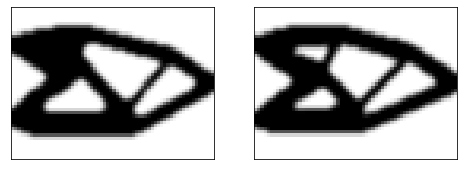

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(8,6),subplot_kw={'xticks': [], 'yticks': []})
ax[0].imshow(ds_cnn4_cb.design.sel(step=100), cmap='Greys')
ax[1].imshow(ds_cnns4_cb.design.sel(step=100), cmap='Greys')

Text(0.5, 0, 'Optimization step')

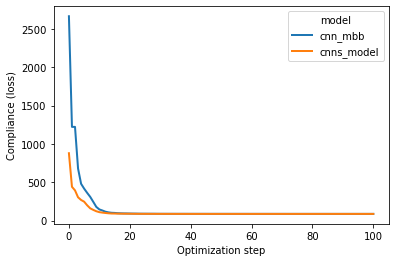

In [29]:
dims = pd.Index(['cnn_mbb', 'cnns_model'], name='model')
ds =  xarray.concat([ds_cnn4_cb, ds_cnns4_cb], dim=dims)
ds.loss.transpose().to_pandas().cummin().loc[:200].plot(linewidth=2)
plt.ylabel('Compliance (loss)')
plt.xlabel('Optimization step')